In [1]:
import cv2
from PIL import Image 
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import shutil
import math
import sys
import random

import SimpleITK as sitk
import nibabel as nib
from Radiomics.Preprocessing.utils.Resample import resample
from scipy import stats

#from sklearn.model_selection import KFold

In [143]:
N4_before = nib.load("/home/seungbin/BraTS2019(Original)/HGG/BraTS19_CBICA_AAP_1/BraTS19_CBICA_AAP_1_flair.nii").get_fdata()
N4_after = nib.load("/home/seungbin/Attention_Unet/DEEPLAB/DATA_SET/2D/BraTS2019/N4/HGG/BraTS19_CBICA_AAP_1/BraTS19_CBICA_AAP_1_flair.nii").get_fdata() 

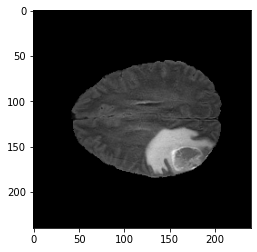

In [150]:
plt.imshow(N4_before[:,:,90], 'gray')

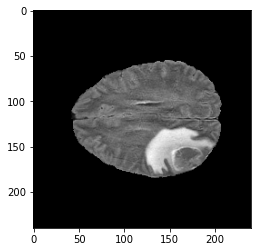

In [151]:
plt.imshow(N4_after[:,:,90], 'gray')

In [172]:
adr =  "/home/seungbin/BraTS2019(Original)/HGG/BraTS19_CBICA_AOD_1/BraTS19_CBICA_AOD_1_"
flair = nib.load(adr + "flair.nii").get_fdata()
seg = nib.load(adr + "seg.nii").get_fdata()
t1 = nib.load(adr + "t1.nii").get_fdata()
t2 = nib.load(adr + "t2.nii").get_fdata()
t1ce = nib.load(adr + "t1ce.nii").get_fdata()

In [173]:
b = z_score(flair)
c = gausian_norm(b)

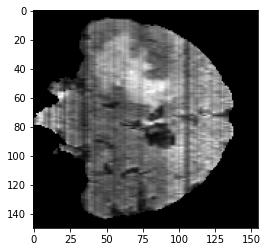

In [213]:
plt.imshow(c[45:195,135,:], 'gray')

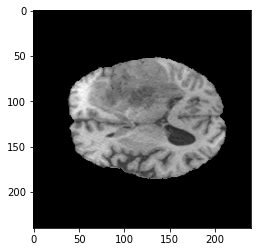

In [186]:
plt.imshow(t1[:,:,67], 'gray')

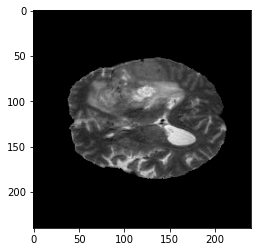

In [187]:
plt.imshow(t2[:,:,67], 'gray')

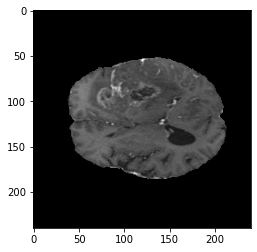

In [188]:
plt.imshow(t1ce[:,:,67], 'gray')

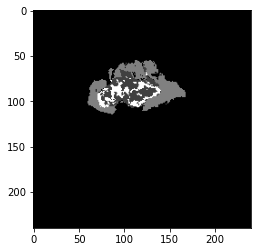

In [185]:
plt.imshow(seg[:,:,67], 'gray')

In [189]:
T, E, W = divide_cls(seg)

In [190]:
B, N = divide_BG(c, W)

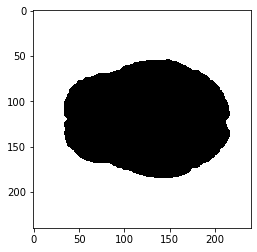

In [115]:
plt.imshow(B[:,:,60], 'gray')

In [191]:
res = result_img(c[:,:,67:68], T[:,:,67:68], E[:,:,67:68], W[:,:,67:68])

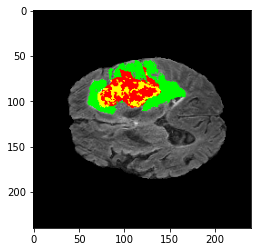

In [192]:
plt.imshow(res[:,:], 'gray')

In [110]:
def divide_cls(seg):
    
    TC = np.zeros(seg.shape)
    EC = np.zeros(seg.shape)
    WT = np.zeros(seg.shape)
    
    for D in range(seg.shape[2]):
        for H in range(seg.shape[1]):
            for W in range(seg.shape[0]):

                if seg[W,H,D] == 1:
                    TC[W,H,D] = 1
                    WT[W,H,D] = 1
                elif seg[W,H,D] == 2:
                    WT[W,H,D] = 1
                elif seg[W,H,D] == 4:
                    EC[W,H,D] = 1
                    TC[W,H,D] = 1
                    WT[W,H,D] = 1
    return TC, EC, WT

In [111]:
def divide_BG(seg, WT):
    
    BG = np.zeros(seg.shape)
    NT = np.zeros(seg.shape)
    
    for D in range(seg.shape[2]):
        for H in range(seg.shape[1]):
            for W in range(seg.shape[0]):
                if seg[W,H,D] > 0:
                    NT[W,H,D] = 1
                    
    BG = cv2.bitwise_not(NT, seg.shape)
    NT = NT - WT
    
    return BG, NT

In [129]:
def devide_col(ch2_img, ch3_img, ch4_img):
    
    ED = ch4_img - ch2_img
    NCR  = ch2_img - ch3_img
    ET = ch3_img
    return NCR, ET, ED

def color_type(NCR, ET, ED):
    RED = NCR+ET
    GREEN = ED+ET
    return RED, GREEN

def GT_color(R, G):
    add_img = np.concatenate((R, G, np.zeros((240,240,1))), axis = 2)
    return add_img

def convert_3d(raw_img):
    Con_img = np.concatenate((raw_img,raw_img,raw_img), axis = 2)
    return Con_img

def result_img(inp, TC, EC, WT):
    cls1, cls2, cls3 = devide_col(TC, EC, WT)
    Red , Green = color_type(cls1, cls2, cls3)
    mask_inv = np.reshape(cv2.bitwise_not(WT), WT.shape)
    other_img = np.reshape(cv2.bitwise_and(mask_inv, inp), np.shape(mask_inv))
    GT_img = GT_color(Red , Green)

    raw = convert_3d(other_img)
    OVR_img = raw + GT_img
    return OVR_img

def arrange_img(X_img, Y_img, Prediction):
    
    GT_img = result_img(X_img[0], Y_img[0])
    Pre_img = result_img(X_img[0], Prediction)
    
    TC = np.concatenate((Prediction[...,2:3], Y_img[0,:,:,2:3], np.zeros((192,192,1))), axis = 2)
    EC = np.concatenate((Prediction[...,3:4], Y_img[0,:,:,3:4], np.zeros((192,192,1))), axis = 2)
    WT = np.concatenate((Prediction[...,4:5], Y_img[0,:,:,4:5], np.zeros((192,192,1))), axis = 2)
    
    return GT_img, Pre_img, TC, EC, WT

In [43]:
def N4Correction(Address, save_dir):
    
    for Subfolder1 in os.listdir(Address):   
        for num, Subfolder2 in enumerate(os.listdir(Address + Subfolder1)):
            for Subfolder3 in os.listdir(Address + Subfolder1 + '/' + Subfolder2):
                target_file = Address + Subfolder1 + '/' + Subfolder2 + '/' + Subfolder3
                
                Send_dir = save_dir + Subfolder1 + '/' + Subfolder2 + '/'
                
                if 'seg.nii' in target_file:
                    
                    if not os.path.exists(Send_dir):
                        os.makedirs(Send_dir)
                        
                    shutil.copy(target_file, Send_dir + Subfolder3)
                    
                elif 'ROI' in target_file:
                    pass
                
                else:
                    target_input = sitk.ReadImage(target_file)
                    maskImage = sitk.OtsuThreshold(target_input,0,1,200)
                    target_input = sitk.Cast(target_input,sitk.sitkFloat32)
                    corrector = sitk.N4BiasFieldCorrectionImageFilter();
                    output_img = corrector.Execute(target_input,maskImage)
                    
                    if not os.path.exists(Send_dir):
                        os.makedirs(Send_dir)
                    
                    sitk.WriteImage(output_img, Send_dir + Subfolder3)
                    
            print(f'Success Processing : {num+1} / {len(os.listdir(Address + Subfolder1))} \r', end="")
        
        print("")
        
    return print("END")

def Cropsize_3D(Address, save_dir, fix_size):
    
    for Subfolder1 in sorted(os.listdir(Address)):   
        for num, Subfolder2 in enumerate(sorted(os.listdir(Address + Subfolder1))):
            
            Send_dir = save_dir + Subfolder1 + '/' + Subfolder2 + '/' 
            
            for num2, Subfolder3 in enumerate(sorted(os.listdir(Address + Subfolder1 + '/' + Subfolder2))):
                target_file = Address + Subfolder1 + '/' + Subfolder2 + '/' + Subfolder3
                
                if not 'seg.nii' in target_file:
                    
                    target = nib.load(target_file).get_data()
    
                    target_W = target.shape[0]
                    target_H = target.shape[1]

                    for W in range(target_W):
                        if np.max(target[W,:,:]) != 0:
                            x0 = W
                            break

                    for rW in range(target_W-1, 0, -1):
                        if np.max(target[rW,:,:]) != 0:
                            x1 = rW
                            break

                    for H in range(target_H):
                        if np.max(target[:,H,:]) != 0:
                            y0 = H
                            break

                    for rH in range(target_H-1, 0, -1):
                        if np.max(target[:,rH,:]) != 0:
                            y1 = rH
                            break

                    Cp_W = x1-x0
                    Cp_H = y1-y0

                    Background = np.zeros((fix_size, fix_size, 155))

                    W1 = (fix_size - Cp_W)/2
                    W2 = fix_size - W1

                    H1 = (fix_size - Cp_H)/2
                    H2 = fix_size - H1

                    Background[math.trunc(W1):math.trunc(W2), math.trunc(H1):math.trunc(H2), :] =  target[x0:x1, y0:y1, :]
                    
                    if not os.path.exists(Send_dir):
                        os.makedirs(Send_dir)
                    
                    np.save(Send_dir + Subfolder3, Background)
                    
                else:
                    
                    target = nib.load(target_file).get_data()
                    
                    seg = np.zeros((fix_size, fix_size, 155))
                    seg[math.trunc(W1):math.trunc(W2), math.trunc(H1):math.trunc(H2), :] =  target[x0:x1, y0:y1, :]
                
                    if not os.path.exists(Send_dir):
                        os.makedirs(Send_dir)
                    
                    np.save(Send_dir + Subfolder3, seg)
                    
            print(f'Success Processing : {num+1} / {len(os.listdir(Address + Subfolder1))} \r', end="")
                       
    return 0

In [3]:
law = '/home/seungbin/BRaTS2018(Original)/miccai_brats_2018_data_training/'
N4 = '/home/seungbin/Attention_Unet/DEEPLAB/DATA_SET/2D/BraTS2018/N4Correction(2021-04-06)/'

N4Correction(law, N4)

Success Processing : 210 / 210 
Success Processing : 75 / 75 
END


In [5]:
law = '/home/seungbin/BraTS2019(Original)/'
crop = '/home/seungbin/Attention_Unet/DEEPLAB/DATA_SET/2D/BraTS2019/Crop/'

Cropsize_3D(law, crop, 192)

/home/seungbin/anaconda3/envs/deeplab/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/seungbin/anaconda3/envs/deeplab/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


0

In [80]:
def CS_zscore(arr):
    
    data = arr.flatten()
    temp_brain = np.zeros((data.shape)).flatten()
    zscored = stats.zscore(data[np.where(data != 0)])
    temp_brain[np.where(data != 0 )] = zscored
    temp = np.reshape(temp_brain,(arr.shape))
    
    return temp

def CS_zscore_norm(arr):
    
    data = arr.flatten()
    temp_brain = np.zeros((data.shape)).flatten()
    zscored = stats.zscore(data[np.where(data != 0)])
    
    if zscored.min() <= 0:
        Z_min = zscored.min()
        zscored = zscored - Z_min
        Z_max = zscored.max()
        zscored = zscored / Z_max
        
    temp_brain[np.where(data != 0 )] = zscored
    temp = np.reshape(temp_brain,(arr.shape))
    
    return temp

def z_score(arr):
    
    result = np.zeros(arr.shape)
    
    for i in range(arr.shape[2]):
        if arr[:,:,i].max() != 0 :
            
            mean = np.mean(arr[:,:,i])
            std = np.std(arr[:,:,i])

            result[:,:,i:i+1] = (arr[:,:,i:i+1] - mean) / std
               
    return result

def gausian_norm(arr):
    
    for i in range(arr.shape[2]):
        
        if arr[:,:,i:i+1].min() != 0:
    
            arr[:,:,i:i+1] = arr[:,:,i:i+1] - arr[:,:,i:i+1].min()
            arr[:,:,i:i+1] = arr[:,:,i:i+1] / arr[:,:,i:i+1].max()
    
    return arr

def min_max(arr):

    uniq = np.unique(arr)
            
    maximum = uniq[int(uniq.shape[0] * 0.99)]
    minimum = uniq[int(uniq.shape[0] * 0.01)]
            
    arr[arr > maximum] = maximum
    arr[arr < minimum] = 0
    
    return arr

def Zero_Y(arr):
    
    for num in range(arr.shape[0]):
        for classes in range(arr.shape[3]):
            for H in range(arr.shape[2]):
                for W in range(arr.shape[1]):
                    
                    if arr[num,W,H,classes] == -1:
                        arr[num,W,H,classes] = 0

    return arr

def NewZero_X(x, y):
    
    Data_x, Data_y = np.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3])), np.zeros((y.shape[0], y.shape[1], y.shape[2],y.shape[3]))
    cnt = 0
    
    for i in range(y.shape[0]):
        if y[i,:,:,4:5].max() != 0:
            Data_x[cnt:cnt+1,:,:,:] = x[i:i+1,:,:,:]
            Data_y[cnt:cnt+1,:,:,:] = y[i:i+1,:,:,:]
            cnt = cnt+1
    
    return Data_x[1:cnt,:,:,:], Data_y[1:cnt,:,:,:]

def NewZero_X2(x, y):
    
    Data_x, Data_y = np.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3])), np.zeros((y.shape[0], y.shape[1], y.shape[2],y.shape[3]))
    cnt = 0
    
    for i in range(x.shape[0]):
        if x[i,:,:,:].max() != 0:
            Data_x[cnt:cnt+1,:,:,:] = x[i:i+1,:,:,:]
            Data_y[cnt:cnt+1,:,:,:] = y[i:i+1,:,:,:]
            cnt = cnt+1
    
    return Data_x[1:cnt,:,:,:], Data_y[1:cnt,:,:,:]

In [20]:
def Pre_processing(Address, save_dir):
    
    for num3,Subfolder1 in enumerate(sorted(os.listdir(Address))):  
        for num, Subfolder2 in enumerate(sorted(os.listdir(Address + Subfolder1))):
            
            Send_dir = save_dir + Subfolder1 + '/' + Subfolder2 + '/' 
            sand = np.zeros((155, 192, 192, 1))
            
            for num2, Subfolder3 in enumerate(sorted(os.listdir(Address + Subfolder1 + '/' + Subfolder2))):
                target_file = Address + Subfolder1 + '/' + Subfolder2 + '/' + Subfolder3
                
                if 'seg' in target_file:
                    seg = np.load(target_file)
                    
                    TC = np.zeros((seg.shape[2],seg.shape[0],seg.shape[1],1))
                    WT = np.zeros((seg.shape[2],seg.shape[0],seg.shape[1],1))
                    EC = np.zeros((seg.shape[2],seg.shape[0],seg.shape[1],1))
                    
                    for D in range(seg.shape[2]):
                        for H in range(seg.shape[1]):
                            for W in range(seg.shape[0]):
                                
                                if seg[W,H,D] == 1:
                                    TC[D,W,H,0] = 1
                                    WT[D,W,H,0] = 1
                                elif seg[W,H,D] == 2:
                                    WT[D,W,H,0] = 1
                                elif seg[W,H,D] == 4:
                                    EC[D,W,H,0] = 1
                                    TC[D,W,H,0] = 1
                                    WT[D,W,H,0] = 1
                                    
                else:
                    
                    inp = np.load(target_file)
                    data = z_score(inp)
                    data = gausian_norm(data)
                    data = np.transpose(data, (2,0,1))
                    #data = np.transpose(inp, (2,0,1))
                    data = np.reshape(data, (data.shape[0], data.shape[1], data.shape[2], 1))
                    
                    sand = np.concatenate([sand, data], axis = -1)
                    
            BG = np.zeros(TC.shape)
            NT = np.zeros(TC.shape)
            
            for D in range(seg.shape[2]):
                for H in range(seg.shape[1]):
                    for W in range(seg.shape[0]):
                        
                        if inp[W,H,D] == 0:
                            BG[D,W,H] = 1
                        elif inp[W,H,D] > 0:
                            NT[D,W,H] = 1
                            
            NT = NT - WT
            
            GT = np.concatenate([BG, NT, TC, EC, WT], axis = -1)
            X_inp = sand[:,:,:,1:]
            
            if not os.path.exists(Send_dir):
                os.makedirs(Send_dir)
                
            print(f'Success Processing : {num+1} / {len(os.listdir(Address + Subfolder1))} \r', end="")
            
            np.save(Send_dir + 'X.npy', X_inp)
            np.save(Send_dir + 'Y.npy', GT)

In [21]:
crop_in = '/home/seungbin/Attention_Unet/DEEPLAB/DATA_SET/2D/BraTS2019/Crop/'
Pre_process = '/home/seungbin/Attention_Unet/DEEPLAB/DATA_SET/2D/BraTS2019/Preprocessing2/'
Pre_processing(crop_in, Pre_process)

In [22]:
def make_Dataset(Address, save_dir):
    for num3,Subfolder1 in enumerate(sorted(os.listdir(Address))):  
        for num, Subfolder2 in enumerate(sorted(os.listdir(Address + Subfolder1))):
            
            Send_dir = save_dir + Subfolder1 + '/' 
            
            for num2, Subfolder3 in enumerate(sorted(os.listdir(Address + Subfolder1 + '/' + Subfolder2))):
                target_file = Address + Subfolder1 + '/' + Subfolder2 + '/' + Subfolder3
                               
                if 'Y' in target_file:
                    Y = np.load(target_file)
                    X = np.load(Address + Subfolder1 + '/' + Subfolder2 + '/X.npy')
                    
                    j = 0
                    
                    for i in range(Y.shape[0]):
                        if np.max(Y[j,:,:,4:], initial = 0) == 0:
                            Y = np.delete(Y, (j), axis = 0)
                            X = np.delete(X, (j), axis = 0)
                        else:
                            j = j + 1
                    
                    if not os.path.exists(Send_dir+str(num)+'/'):
                        os.makedirs(Send_dir+str(num)+'/')
                        
                    np.save(Send_dir+str(num)+'/X.npy', X)
                    np.save(Send_dir+str(num)+'/Y.npy', Y)

In [23]:
Pre_processing = '/home/seungbin/Attention_Unet/DEEPLAB/DATA_SET/2D/BraTS2019/Preprocessing2/'
apt = '/home/seungbin/Attention_Unet/DEEPLAB/DATA_SET/2D/BraTS2019/test2/'

make_Dataset(Pre_processing, apt)

In [24]:
def fold_data(Address, save_dir, fold):
    
    j = 0 
    for num3,Subfolder1 in enumerate(sorted(os.listdir(Address))):
        
        file_num  = len(os.listdir(Address + Subfolder1))
        fold_num = round(file_num / fold)
        
        for num, Subfolder2 in enumerate(sorted(os.listdir(Address + Subfolder1))):
            
            now_fold = math.trunc(num / fold_num)
            if now_fold == fold:
                now_fold = now_fold - 1
            j = j + 1 
                
            Send_dir = save_dir + str(now_fold) + '/'
            
            if not os.path.exists(Send_dir + str(j)):
                        os.makedirs(Send_dir + str(j))
            
            for num2, Subfolder3 in enumerate(sorted(os.listdir(Address + Subfolder1 + '/' + Subfolder2))):
                target_file = Address + Subfolder1 + '/' + Subfolder2 + '/' + Subfolder3
      
                shutil.copy(target_file, Send_dir + str(j) + '/'+ Subfolder3)

In [25]:
adr = '/home/seungbin/Attention_Unet/DEEPLAB/DATA_SET/2D/BraTS2019/test2/'
sdr = "/home/seungbin/Attention_Unet/DEEPLAB/DATA_SET/2D/BraTS2019/fold_data3/"
fold_data(adr, sdr, 5)

In [26]:
def struct(Address, save_dir):

    for num3,Subfolder1 in enumerate(sorted(os.listdir(Address))):
        
        X_concat = np.zeros((1,192,192,4))
        Y_concat = np.zeros((1,192,192,5))
        
        for num, Subfolder2 in enumerate(sorted(os.listdir(Address + Subfolder1))):
            for num2, Subfolder3 in enumerate(sorted(os.listdir(Address + Subfolder1 + '/' + Subfolder2))):
                target_file = Address + Subfolder1 + '/' + Subfolder2 + '/' + Subfolder3
                #                           1~5               1~N                X,Y
                if 'X' in Subfolder3:
                    X = np.load(target_file)
                    X_concat = np.concatenate([X_concat, X], axis = 0)
                    #print(Subfolder2)
                elif 'Y' in Subfolder3:
                    Y = np.load(target_file)
                    Y_concat = np.concatenate([Y_concat, Y], axis = 0)
                    
        np.save(save_dir + 'X_' + Subfolder1+'.npy', X_concat[1:])
        np.save(save_dir + 'Y_' + Subfolder1+'.npy', Y_concat[1:])
    return 0

In [27]:
fold = '/home/seungbin/Attention_Unet/DEEPLAB/DATA_SET/2D/BraTS2019/fold_data3/'
struct(fold, fold)

0

In [25]:
a = np.load('/home/seungbin/Attention_Unet/DEEPLAB/DATA_SET/2D/BraTS2020/fold_data/3/200/X.npy')
a = a[:,:,:,:4]

In [26]:
a.shape

(75, 192, 192, 4)

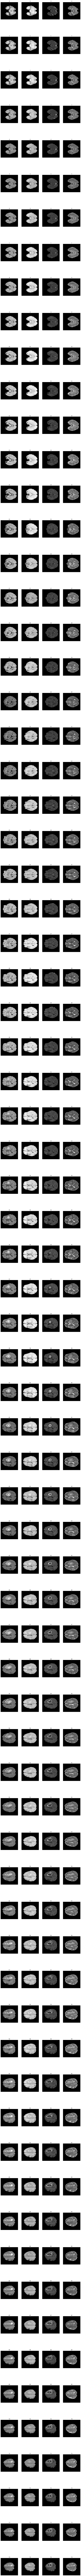

In [27]:
numpy_visual('/home/seungbin/Attention_Unet/DEEPLAB/DATA_SET/2D/BraTS2020/fold_data/3/200/X.npy', a)

In [28]:
np.save('/home/seungbin/Attention_Unet/DEEPLAB/DATA_SET/2D/BraTS2020/fold_data/3/200/X.npy', a)

In [19]:
def numpy_visual(Data):
    
    Dataset = Data
    
    cls = Dataset.shape[3]
    cnt = Dataset.shape[0]
    fig, ax = plt.subplots(cnt, cls, figsize = (15, 500)) # 4 , 15 , 300
    
    for i in range(cnt):
        for j in range(cls):
            
            ax[i,j].imshow(Dataset[i,:,:,j], cmap = 'gray')
            ax[i,j].axis("off")
            ax[i,j].set_title(i)
            
def Data_1visual(Address):
    
    seg = nib.load(Address).get_data()
    seg_shape = int(seg.shape[2]/5)
    fig, ax = plt.subplots(seg_shape, 5, figsize = (20, 250))
    
    k = 0
    
    for i in range(seg_shape):
        for j in range(5):
            
            ax[i,j].imshow(seg[:,:,k], cmap = 'gray')
            ax[i,j].axis("off")
            ax[i,j].set_title(k)
            
            k+=1

In [18]:
save = '/home/seungbin/Attention_Unet/DEEPLAB/DATA_SET/2D/BraTS2019/test/' 
test(Crop, save)

In [3]:
def shuffle(x, y):
    Data_x = np.copy(x)
    Data_y = np.copy(y)
    
    for i in range(x.shape[0]):
        
        print(f'Success Processing : {i+1} / {x.shape[0]} \r', end="")
        
        number = random.randint(0, x.shape[0]-1)
        change_dataX = np.copy(Data_x[number])
        change_dataY = np.copy(Data_y[number])
        
        Data_x[number] = np.copy(Data_x[i])
        Data_y[number] = np.copy(Data_y[i])
        
        Data_x[i] = change_dataX
        Data_y[i] = change_dataY
    
    return Data_x, Data_y

In [4]:
def mix_data(X_HGG, Y_HGG, X_LGG, Y_LGG, D_rate):#0.2

    H_size = int(X_HGG.shape[0] * D_rate)
    L_size = int(X_LGG.shape[0] * D_rate)

    Xtrain = np.concatenate((X_HGG[H_size:,:,:,:], X_LGG[L_size:,:,:,:]), axis = 0)
    Ytrain = np.concatenate((Y_HGG[H_size:,:,:,:], Y_LGG[L_size:,:,:,:]), axis = 0)

    Xval = np.concatenate((X_HGG[:H_size,:,:,:], X_LGG[:L_size,:,:,:]), axis = 0)
    Yval = np.concatenate((Y_HGG[:H_size,:,:,:], Y_LGG[:L_size,:,:,:]), axis = 0)

    print('Xtrain :' + str(Xtrain.shape))
    print('Ytrain :' + str(Ytrain.shape))
    print('Xval :' + str(Xval.shape))
    print('Yval :' + str(Yval.shape))
    
    return Xtrain, Ytrain, Xval, Yval